# MODELO CLASIFICADOR XGBOOST - FEATURE SELECTION

Ayuda para la realización de este notebook: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

De los 3 casos analizados, el mejor modelo es **XGBOOST** con **n_estimators=500**. De aquí en adelante tan solo analizaré mejoras en este modelo.

#### Memoria de lo realizado hasta ahora:

* Se comprobó en el notebook *Modelo_clasificador_3.ipynb* que resultaba algo mejor utilizar un tamaño de 2 años y descartar el 1 año del dataset por tratarse de un escenario muy distinto al actual.

* Se eliminó la variable *ACOPLADO_FR* al no aportar ninguna mejora para evitar considerar ruido.

Al entrenar el modelo XGBoost en *Modelo_clasificador_3.ipynb* y recuperar la importancia de los features que lo componen, se vió como realmente había 5 variables que resaltaban frente a las demás. En este notebook recupero este modelo (guardado en path='/Users/blancabengoa/Desktop/KSchool/TFM/Modelo3/') y la división de train-test utilizada y analizo si mejoraría mi accuracy si solo me quedase con las variables más importantes. 

Aunque no se trata de un dataset con un excesivo número de características, compruebo que el hecho de considerar "ruido" no distorsione mi resultado.

**Librerías necesarias**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import altair as alt

%matplotlib inline
plt.style.use('ggplot')

#Librerías para modelos

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, confusion_matrix, precision_score

In [2]:
pd.options.display.max_columns= None

Descargo los resultados de *Modelo_Clasificador_3.ipynb*

In [3]:
path='/Users/blancabengoa/Desktop/KSchool/TFM/Modelo3/'

In [4]:
X_train = pickle.load(open(path + "X_train.pkl","rb"))
X_test = pickle.load(open(path + "X_test.pkl","rb"))
y_train = pickle.load(open(path + "y_train.pkl","rb"))
y_test = pickle.load(open(path + "y_test.pkl","rb"))

In [5]:
model=pickle.load(open(path + "clfxb_3.pkl","rb"))

### Recupero resultados del modelo:

#### 1) Parámetros

In [6]:
print(model.get_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': nan, 'n_estimators': 500, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}


Tan solo he ajustado el número de estimadores (óptimo=500).

Queda pendiente en futuras mejoras del modelo ajustar otros hiperparámetros individuales del árbol como:

* max_depth: máxima profundidad del árbol. Cuanto más bajo, menos posibilidad de overfitting (buscar equilibrio para no caer en underfitting).

* gamma: a mayor gamma, más conservador. Especifica la mínima reducción de la función de pérdidas para dividir un nodo. 


#### 2) Accuracy, classification report

In [9]:
print('Accuracy: %.2f' %(accuracy_score(y_test, model.predict(X_test))))
print(classification_report(y_test,model.predict(X_test)))

Accuracy: 0.70
             precision    recall  f1-score   support

          0       0.70      0.55      0.62      1518
          1       0.71      0.82      0.76      1986

avg / total       0.70      0.70      0.70      3504



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### 3) Importancia de las variables en el modelo:

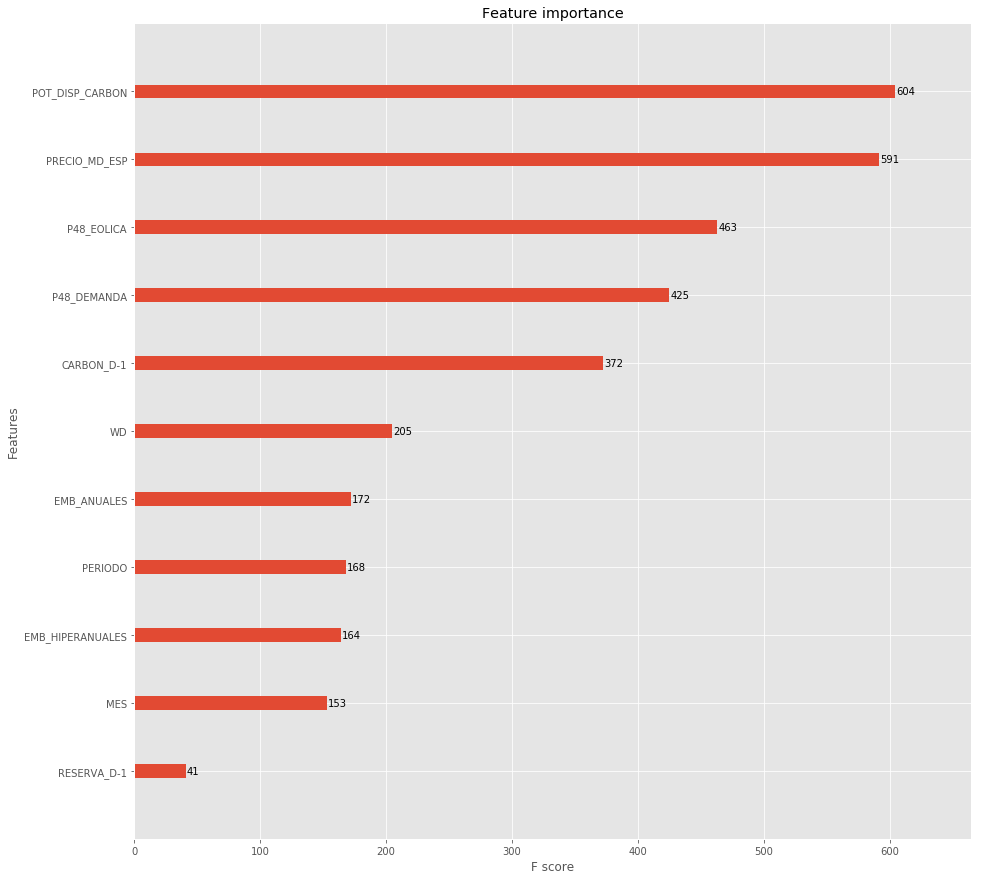

In [10]:
plot_importance(model)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

**NOTA:** Estoy utilizando como medida de la importancia la opción *weight*: cantidad de veces que se usa una función para dividir los datos en todos los árboles.

#### 4) Feature selection

Utilizo SelectFromModel de la librería sklearn:

In [11]:
thresholds = sorted(model.feature_importances_)
thresholds

[0.012209648,
 0.045562834,
 0.048838593,
 0.05002978,
 0.051220965,
 0.061048243,
 0.110780224,
 0.12656343,
 0.13787968,
 0.17599761,
 0.17986897]

In [12]:
model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 500,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [13]:
for t in thresholds:
    selection = SelectFromModel(model, threshold=t, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # Entreno con el nuevo set de training:
    selection_model = XGBClassifier(n_estimators=500,random_state=42)
    selection_model.fit(select_X_train, y_train)
    # Resultados:
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (t, select_X_train.shape[1], accuracy*100.0))
    print(classification_report(y_test, y_pred))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.012, n=11, Accuracy: 70.41%
             precision    recall  f1-score   support

          0       0.70      0.55      0.62      1518
          1       0.71      0.82      0.76      1986

avg / total       0.70      0.70      0.70      3504



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.046, n=10, Accuracy: 70.03%
             precision    recall  f1-score   support

          0       0.70      0.54      0.61      1518
          1       0.70      0.82      0.76      1986

avg / total       0.70      0.70      0.69      3504



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.049, n=9, Accuracy: 70.15%
             precision    recall  f1-score   support

          0       0.70      0.54      0.61      1518
          1       0.70      0.83      0.76      1986

avg / total       0.70      0.70      0.69      3504



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.050, n=8, Accuracy: 69.49%
             precision    recall  f1-score   support

          0       0.70      0.52      0.60      1518
          1       0.69      0.83      0.75      1986

avg / total       0.70      0.69      0.69      3504



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.051, n=7, Accuracy: 69.24%
             precision    recall  f1-score   support

          0       0.69      0.52      0.60      1518
          1       0.69      0.82      0.75      1986

avg / total       0.69      0.69      0.68      3504



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.061, n=6, Accuracy: 68.98%
             precision    recall  f1-score   support

          0       0.69      0.52      0.59      1518
          1       0.69      0.82      0.75      1986

avg / total       0.69      0.69      0.68      3504



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.111, n=5, Accuracy: 66.47%
             precision    recall  f1-score   support

          0       0.66      0.46      0.54      1518
          1       0.67      0.82      0.74      1986

avg / total       0.66      0.66      0.65      3504



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.127, n=4, Accuracy: 67.21%
             precision    recall  f1-score   support

          0       0.68      0.47      0.55      1518
          1       0.67      0.83      0.74      1986

avg / total       0.67      0.67      0.66      3504



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.138, n=3, Accuracy: 66.55%
             precision    recall  f1-score   support

          0       0.67      0.45      0.54      1518
          1       0.66      0.83      0.74      1986

avg / total       0.67      0.67      0.65      3504



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Thresh=0.176, n=2, Accuracy: 66.47%
             precision    recall  f1-score   support

          0       0.68      0.43      0.53      1518
          1       0.66      0.84      0.74      1986

avg / total       0.67      0.66      0.65      3504

Thresh=0.180, n=1, Accuracy: 67.32%
             precision    recall  f1-score   support

          0       0.69      0.44      0.54      1518
          1       0.67      0.85      0.75      1986

avg / total       0.68      0.67      0.66      3504



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


He comprobado que mi accuracy empeora si disminuyo el número de features a partir de n=8, a pesar de tener una importancia baja en el modelo las variables a partir de n=5. Con las métricas de Precision, Recall y F1-score ocurre lo mismo.

En el libro *Hands-On Machine Learning with Scikit-Learn & TensorFlow*, página 25, nos indican:

*"Garbage in, garbage out. Your system will only be capable of learning if the training data contains enough relevant features and not too many irrelevant ones"*

So...elimino de mi dataset de entrenamiento RESERVA_D-1 y MES, y me quedo con 9 variables.

Preparo todo para guardarlo como en los casos anteriores.

In [14]:
X_train_def=X_train.drop(['RESERVA_D-1','MES'],axis=1).copy()
y_train_def=y_train.copy()
X_test_def=X_test.drop(['RESERVA_D-1','MES'],axis=1).copy()
y_test_def=y_test.copy()

In [15]:
X_train_def.head(3)

,PERIODO,WD,PRECIO_MD_ESP,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES
11884,6,2,43.44,8329.3,23978.8,8826.1,205.73,4613,3588
23434,14,7,52.04,3307.4,25200.9,9153.6,299.12,6923,4954
19929,12,1,69.48,1206.4,37832.1,8826.9,284.25,3213,2185


In [16]:
X_train_def.describe()

,PERIODO,WD,PRECIO_MD_ESP,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES
count,14014.000000,14014.000000,14014.000000,14014.000000,14014.000000,14014.000000,14014.000000,14014.000000,14014.000000
mean,12.478878,4.093335,53.979276,5340.711774,28876.317169,8532.410532,320.118353,4286.529685,3441.738975
std,6.921449,2.018750,12.591399,3136.525095,4666.643239,716.687666,46.930854,1447.392807,906.712491
min,1.000000,1.000000,2.060000,240.800000,18277.400000,5693.700000,151.940000,2222.000000,2138.000000
25%,6.000000,2.000000,46.690000,2919.100000,24899.225000,8089.200000,293.002500,3213.000000,2712.000000
50%,12.000000,4.000000,53.380000,4687.650000,29068.100000,8618.500000,330.665000,4017.000000,3421.000000
75%,18.000000,6.000000,62.300000,7085.750000,32519.475000,9128.800000,352.460000,5172.000000,4266.000000
max,24.000000,7.000000,101.990000,16952.600000,41297.900000,9534.700000,517.780000,7092.000000,5004.000000


In [17]:
X_test_def.describe()

,PERIODO,WD,PRECIO_MD_ESP,P48_EOLICA,P48_DEMANDA,POT_DISP_CARBON,CARBON_D-1,EMB_ANUALES,EMB_HIPERANUALES
count,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000,3504.000000
mean,12.589897,4.083904,53.836416,5437.768579,28826.559618,8512.808818,319.853231,4274.344178,3434.720890
std,6.924652,2.055422,12.618407,3161.253637,4645.140561,741.276755,47.396328,1462.743950,910.379994
min,1.000000,1.000000,2.300000,454.400000,18501.100000,5693.700000,154.500000,2222.000000,2138.000000
25%,7.000000,2.000000,46.460000,3021.250000,24849.725000,8064.900000,290.617500,3148.000000,2560.000000
50%,13.000000,4.000000,53.195000,4711.250000,29016.450000,8617.800000,330.170000,4017.000000,3363.000000
75%,19.000000,6.000000,62.102500,7333.700000,32380.525000,9119.900000,352.960000,5172.000000,4143.000000
max,24.000000,7.000000,100.670000,16471.600000,40921.600000,9534.700000,504.980000,7092.000000,5004.000000


In [18]:
clfxb_4=XGBClassifier(n_estimators=500,random_state=42)

In [19]:
clfxb_4.fit(X_train_def,y_train_def)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [20]:
print("Accuracy: %.2f%%" % (accuracy_score(y_test_def, clfxb_4.predict(X_test_def))))
print(classification_report(y_test_def, clfxb_4.predict(X_test_def)))

Accuracy: 0.70%
             precision    recall  f1-score   support

          0       0.70      0.54      0.61      1518
          1       0.70      0.83      0.76      1986

avg / total       0.70      0.70      0.69      3504



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [21]:
path='/Users/blancabengoa/Desktop/KSchool/TFM/Modelo4/'   #Aqui es donde debo poner la ruta especifica

In [22]:
pickle.dump(clfxb_4,open(path +"clfxb_4.pkl","wb"))

In [23]:
#set de datos
pickle.dump(X_train_def,open(path + "X_train.pkl","wb"))
pickle.dump(y_train_def,open(path + "y_train.pkl","wb"))
pickle.dump(X_test_def,open(path + "X_test.pkl","wb"))
pickle.dump(y_test_def,open(path + "y_test.pkl","wb"))